In [1]:
#importing some useful packages
import os #import operating system
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import stats
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# 'direction_original' es la direccion de las imagenes originales de ahí se va a sacar el nombre, 'image' es
# la lista de imagenes que se quiere guardar en la carpeta de salida y 'image_description' es el nombre de la
# imagen con la que se quiere guardar, ejemplo "gray", "canny", etc.
def save_images_output (direction_original, image, image_description):
    image_name = []
    image_names = os.listdir(direction_original)
    directory_output = 'test_images_output/'
    for i in range(len(image_names)):
        image_name.append(directory_output + image_description + image_names[i])
        cv2.imwrite(image_name[i], image[i])
        #print(image_name[i])
    return

def read_images(names):
    images = []
    for i in range(len(names)):
        path = mpimg.imread(names[i])
        images.append(path)
    return images

def print_images(images, cmap):
    figure_size = (15,15)
    plt.figure(figsize = figure_size)
    for i in range(len(images)):
        plt.subplot(3,2,i+1)
        plt.title(original_image_names[i])
        plt.xlabel('Pixels')
        plt.ylabel('Pixels')
        plt.tight_layout()
        if cmap == 'gray':
            plt.imshow(images[i],cmap='gray')
        if cmap == 'None':
            plt.imshow(images[i])
    return

def grayscale(images):
    gray_scale_images = []
    for i in range(len(images)):
        image_temp = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        gray_scale_images.append(image_temp)
    return gray_scale_images
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(images, kernel_size):
    gaussian_blur_images = []
    for i in range(len(images)):
        image_temp = cv2.GaussianBlur(images[i], (kernel_size, kernel_size), 0)
        gaussian_blur_images.append(image_temp)
    return gaussian_blur_images

def canny(images, low_threshold, high_threshold):
    canny_images = []
    for i in range(len(images)):
        image_temp = cv2.Canny(images[i], low_threshold, high_threshold)
        canny_images.append(image_temp)
    return canny_images

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def masked_images(images,vertices):
    masked_images = []
    for i in range(len(images)):
        image_temp = region_of_interest(images[i], vertices)
        masked_images.append(image_temp)
    return masked_images

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img,lines

def hough_lines_images (images, rho, theta, threshold, min_line_length, max_line_gap):
    line_image = []
    lines = []
    for i in range(len(images)):
        line_image_temp,lines_temp = hough_lines(images[i], rho, theta, threshold, min_line_length, max_line_gap)
        line_image.append(line_image_temp)
        lines.append(lines_temp)
    return line_image,lines

def weighted_img(image_lines, image_copy, α=0.8, β=1., γ=0.):
    """
    `image_lines` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `image_copy` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: image_copy and image_lines must be the same shape!
    """
    weighted_images = []
    for i in range(len(image_copy)):
        image_temp = cv2.addWeighted(image_copy[i], α, image_lines[i], β, γ)
        weighted_images.append(image_temp)
    return weighted_images

def separate_lines(lines, img):
    img_shape = img.shape
    
    middle_x = img_shape[1] / 2
    
    left_lane_lines = []
    right_lane_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            dx = x2 - x1 
            if dx == 0:
                #Discarding line since we can't gradient is undefined at this dx
                continue
            dy = y2 - y1
            
            # Similarly, if the y value remains constant as x increases, discard line
            if dy == 0:
                continue
            
            slope = dy / dx
            
            # This is pure guess than anything... 
            # but get rid of lines with a small slope as they are likely to be horizontal one
            epsilon = 0.1
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0 and x1 < middle_x and x2 < middle_x:
                # Lane should also be within the left hand side of region of interest
                left_lane_lines.append([[x1, y1, x2, y2]])
            elif x1 >= middle_x and x2 >= middle_x:
                # Lane should also be within the right hand side of region of interest
                right_lane_lines.append([[x1, y1, x2, y2]])
    
    return left_lane_lines, right_lane_lines

def separate_lines_images (lines, line_images):
    left_line = []
    right_lines = []
    
    for i in range(len(line_images)):
        left_line_temp,right_lines_temp  = separate_lines(lines[i], line_images[i])
        left_line.append(left_line_temp)
        right_lines.append(right_lines_temp)    
    return left_line, right_lines

def draw_lines_images (images,lines_to_draw, color, thickness):
    for i in range(len(images)):
        draw_lines(images[i], lines_to_draw[i], color, thickness)
    return

def find_lane_lines_formula(lines):
    xs = []
    ys = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            xs.append(x1)
            xs.append(x2)
            ys.append(y1)
            ys.append(y2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    
    # Remember, a straight line is expressed as f(x) = Ax + b. Slope is the A, while intercept is the b
    return (slope, intercept)

def linear_regression_calculation (lines):
    slope = []
    intercept = []
    for i in range(len(lines)):
        slope_left_temp, intercept_left_temp = find_lane_lines_formula(lines[i])
        slope.append(slope_left_temp)
        intercept.append(intercept_left_temp)
    return slope, intercept

# To graph the extrapolate lane lines we need 4 points to draw a line.
# Points #1 and #2 corresponds to left line.
# Points #3 and #4 corresponds to right line.
def Extrapolane (slope_left,intercept_left,slope_right,intercept_right,image):
    # Grab the x and y sizes of each image
    ysize_image = image.shape[0]
    xsize_image = image.shape[1]
    Line_thickness = 10
    
    ###LINEA IZQUIERDA
    # Se calcula el punto1 cuando el valor de Y=ysize_image. Mirar foto del cuaderno.
    X_Point_1 = ((ysize_image-intercept_left)/slope_left)
    # Se convierte a entero porque la funcion de cv2.line solo permite enteros
    X_Point_1 = int(X_Point_1)
    # El valor Y_Point_1 = ysize_image ya que se quiere que la linea arranque en el filo inferior
    Y_Point_1 = ysize_image
    # El punto 2 se calcula con la mitad de la imagen .1 pixel y calcular el punto Y con la ecuación de la línea recta
    X_Point_2 = int((xsize_image/2)-1)
    Y_Point_2 = int((slope_left*X_Point_2)+intercept_left)
    
    cv2.line(image,(X_Point_1,Y_Point_1),(X_Point_2,Y_Point_2),(0,255,0),Line_thickness)

    ###LINEA DERECHA

    # Se calcula el punto1 cuando el valor de Y=ysize_image. Mirar foto del cuaderno.
    X_Point_3 = ((ysize_image-intercept_right)/((slope_right)))
    # Se convierte a entero porque la funcion de cv2.line solo permite enteros
    X_Point_3 = int(X_Point_3)
    # El valor Y_Point_1 = ysize_image ya que se quiere que la linea arranque en el filo inferior
    Y_Point_3 = ysize_image
    # El punto 2 se calcula con la mitad de la imagen .1 pixel y calcular el punto Y con la ecuación de la línea recta
    X_Point_4 = int((xsize_image/2)-1)
    Y_Point_4 = int((slope_right*X_Point_4)+intercept_right)
    
    cv2.line(image,(X_Point_3,Y_Point_3),(X_Point_4,Y_Point_4),(255,0,0),Line_thickness)
       
    #plt.imshow(image)
    #plt.show()
    return image

def extrapolane_images (images, slope_left, intercept_left, slope_right, intercept_right):
    image_with_line = []
    for i in range(len(images)):
        image_with_line_temp = Extrapolane (slope_left[i],intercept_left[i],slope_right[i],intercept_right[i],images[i])
        image_with_line.append(image_with_line_temp)
    return image_with_line

In [3]:
# Making sure we import our images with the right names
test_img_dir = "test_images/"

#Se crea un array con el nombre de todas las imagenes que están en la carpeta test_images
original_image_names = os.listdir(test_img_dir)
original_image_names = list(map(lambda name: test_img_dir + name, original_image_names))

print(original_image_names) #print all images names are saved in test_images folder

['test_images/whiteCarLaneSwitch.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/solidYellowCurve2.jpg']


In [4]:
original_images = read_images(original_image_names)
copy1_images = read_images(original_image_names)
copy2_images = read_images(original_image_names)
copy3_images = read_images(original_image_names)

In [5]:
#print_images(original_images,'None')
save_images_output ("test_images/", original_images, "Original_")

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #

    # Create a copy of the image
    processed_image = image.copy()
    copy_image = image.copy()
    # Gray scale
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_RGB2GRAY)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    processed_image = cv2.GaussianBlur(processed_image, (kernel_size, kernel_size), 0)
    #Define Low Threshold and High Threshold for Canny
    low_threshold = 50
    high_threshold = 150
    processed_image = cv2.Canny(processed_image, low_threshold, high_threshold)
    # Define vertices of Region to select the lines
    left_bottom = [110, 500]
    right_bottom = [870, 500]
    apex = [480, 309]
    vertices = np.array([[left_bottom,right_bottom,apex]], dtype=np.int32)
    region_of_interest_images = region_of_interest(processed_image, vertices)
    
    rho = 1
    theta = np.pi/180
    threshold = 15
    min_line_length = 20
    max_line_gap = 10
    line_image,lines = hough_lines(region_of_interest_images, rho, theta, threshold, min_line_length, max_line_gap)
    α=0.8
    β=1.
    γ=0.
    new = cv2.addWeighted(copy_image, α,line_image, β, γ)

    left_lines, right_lines = separate_lines(lines, new)
    
    slope_left, intercept_left = find_lane_lines_formula(left_lines)
    slope_right, intercept_right = find_lane_lines_formula(right_lines)

    final = Extrapolane (slope_left,intercept_left,slope_right,intercept_right,image)
    
    
    
    
    # separate_lines_images
    # Dibujar linea izquierda y derecha
    # linear_regression_calculation para izq y dere
    # image_lines_final
    
    result = final
    return result

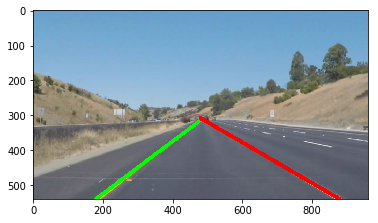

In [7]:
test = process_image(original_images[0])
plt.imshow(test, 'gray')

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 13.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.32 s, sys: 640 ms, total: 3.96 s
Wall time: 16.7 s


In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:48<00:00, 13.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.2 s, sys: 629 ms, total: 10.8 s
Wall time: 50.1 s


In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 90%|█████████ | 114/126 [00:13<00:02,  5.99it/s]


ValueError: Inputs must not be empty.